In [1]:
import os
import joblib
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from model_settings import ms
from plotters import PlotCols
def HistCols(df,cols):
    fig,axs=plt.subplots(len(cols))
    for i,col in enumerate(cols):
        axs[i].hist(hists[col],label=col.replace('_',' '),color='purple',bins=int(np.sqrt(hists.shape[0])))
        axs[i].legend()

In [2]:
ms.find_root(Path())
models_dir = Path(os.path.join(ms.root,ms.trained_models)).parent
models = pd.Series([f for f in os.listdir(models_dir) if f.endswith('.pkl')])
print(models)

0    2024-11-09 124248013907 retrained_relative_asi...
dtype: object


In [3]:
model = joblib.load(os.path.join(models_dir,models[0]))
model.keys()

dict_keys(['errors', 'models'])

In [4]:
errors = model['errors']
models = model['models']

['cpu', 'isMAE', 'isRMSE', 'osMAE', 'osRMSE']


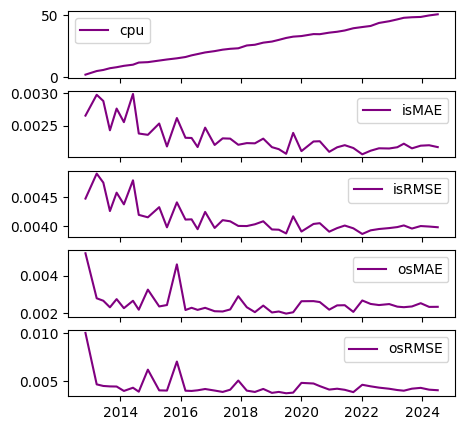

In [5]:
PlotCols(errors,figsize=(5,5))

In [6]:
dates = pd.Series([d for d in models.keys()])
dates.describe()[['min','max']]

min    2012-11-06 00:00:00
max    2024-07-08 00:00:00
dtype: object

In [8]:
model = models[dates.iloc[-1]]
data = model['train_data']
pricename = [n for n in data.columns if n.find('barrier_price')!=-1 or n.find('asian_price')!=-1][0]

In [9]:
df = data.copy()
df['observed_price'] = df['relative_observed']*df['strike_price']
df['pricing_error'] = df['observed_price']-df[pricename]
df['relative_error'] = df['pricing_error']/df[pricename]
df['squared_error'] = df['pricing_error']**2
df['absolute_error'] = np.abs(df['pricing_error'])
df['absolute_relative'] = np.abs(df['relative_error'])
hists = df[df[pricename]>0.01*df['spot_price']].iloc[:,-6:].copy()
hists[pricename] = df[pricename]
desc = hists.describe()
MAE = desc.loc['mean','absolute_error']
RMSE = np.sqrt(desc.loc['mean','squared_error'])
MARE = desc.loc['mean','absolute_relative']
print(f"MAE:\n   {round(MAE,4)}\nRMSE:\n   {round(RMSE,4)}\nMARE:\n   {round(100*MARE,4)}%")

MAE:
   6.5611
RMSE:
   10.505
MARE:
   0.7998%


In [10]:
estimation = df['observed_price']
target = df[pricename]
relative = df['relative_error']

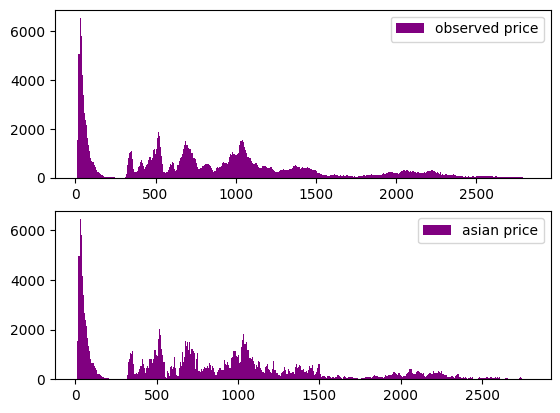

In [11]:
cols = ['observed_price','asian_price']
HistCols(hists,cols)

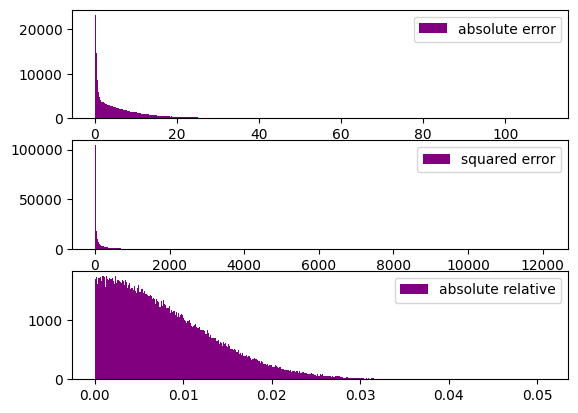

In [12]:
cols = ['absolute_error','squared_error','absolute_relative']
HistCols(hists,cols)